# 3. Modeling
**Andrew Dang**  

**BrainStation, Data Science**  

**Previous Notebook: 2. EDA and Feature Engineering**

**Next Notebook: 4. Findings**

In the previous notebook, we did some initial analysis to explore the relationship between our input and target variables. 
In this notebook, we will be modeling. 

We are trying to predict a rating between 0 and 100, so we want to use a regression model. The evaluation metric used to determine which model performs best is the mean absolute error, which is the absolute difference the predicted rating and the actual rating averaged across the entire dataset. 

In this notebook, I want to test the following models. 

1. Decision Tree Regressor
2. KNN Regressor
3. Ridge Regression
4. Lasso Regression
5. XGBoost Regression
5. Fully connected neural networks. 

As we are dealing with text data, we need to represent the text data in numeric form. There are different options for this. We will explore the following options. 

1. Bag of Words (CountVectorizer)
2. TF-IDF 
3. word2Vec embeddings
4. GloVe word embeddings

Another thing to consider is whether to use stemming or lemmatization. Stemming often leads to tokens with odd or incorrect spellings that are more difficult to interpret. Therefore, we want to focus our efforts on using lemmatization. 

We are interested in seeing what words increase/decrease the rating of a whisky. Some words are positive or negative by definition, and don't reveal much information about the whisky. Therefore, to try and get a better understanding of whisky specific language, we want to include these positive and negative words in our list of stop words (words that are ignored and do not get tokenized). We also want to do the same thing with the name of the distillers, as their appearance in a review will not tell us much about the whisky. We will also add the names of the individual distilleries into the list of stop words. This was previosuly done in another notebook, and we will simply load them here. 

Now let's load in our packages. 


In [1]:
# Basic data science packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Text data packages
import nltk
import re
import string
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Other required packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Data preprocessing packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

# modeling and metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor

# Additional NLP packages
from sklearn.feature_extraction import text
from nltk.stem import WordNetLemmatizer

import pickle
import joblib

from sklearn.pipeline import Pipeline
from xgboost import plot_importance

# Neural network packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gensim
from gensim.utils import simple_preprocess
from tensorflow.keras.callbacks import EarlyStopping

***

## Defining functions and other utilities
In the next few code blocks, we are doing the following:

- Loading in our custom stop words that consists of positive and negative adjectives and whisky distiller names in addition to the default list of stop words.
- Creating our lemmatizer for our text vectorizers. 
- Define a custom error and scoring function. Our scores are between 0 and 100, but there is nothing stopping our models from predicting ratings beyond these lower and upper boundaries. Our custom error function will clip all predictions below 0 to equal 0, and all predictions above 100 to 100. The custom scoring function will be passed to our models so that the predictions can be clipped during the cross-validation process. 

**Loading custom stop words**

In [2]:
# open pickled custom stopwords
my_stop_words = joblib.load('data/my_stop_words.pkl')


**Creating lemmatizer**

In [3]:
# Creating lemmatizer
# Download and instantiate the lemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def my_lemmatizer(sentence):
    '''
    Takes in a string and removes punctuation, lower cases the text, and lemmatizes the text.
    Returns a list of lemmatized words. 
    
    Inputs
    ------
    sentence: a string
    
    Returns
    -------
    listoflemmad_words: list of lemmatized words. 
    '''
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listoflemmad_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in my_stop_words and (word!='')):
            # Stem words
            lemmad_word = lemmatizer.lemmatize(word, pos='v')
            listoflemmad_words.append(lemmad_word)

    return listoflemmad_words

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Creating custom error and scorer.**

In [4]:
# build a custom scorer
def clipped_mae(y_true, y_pred):
    '''
    A function that clips predictions above 100 to equal 100, and clip predictions under 0 to equal 0. 
    
    Inputs:
    -------
    y_true: Actual label
    y_pred: Predicted label
    
    Returns:
    -------
    clipped_mae: The mean absolute error where predictions are clipped to remain within the boundaries of 0-100.
    
    '''
    clip1 = np.where(y_pred < 0, 0, y_pred)
    clip2 = np.where(clip1 > 100, 100, clip1)
    clipped_mae = mean_absolute_error(y_true, clip2)
    return clipped_mae

scoring = make_scorer(clipped_mae, greater_is_better=False)

***

## Loading fitted models
The following function will load models that have already been fitted on the training data. This will prevent the need to refit the models every time this notebook is opened. 

**If you wish to see the entire fitting process, uncomment the third code block and run it.**  
**Having the `models_loaded_flag=False` will cause each model to be re-fitted. This will take ~20-30 minutes to run.**

In [5]:
def load_fitted_models():
    '''
    Function that loads fitted models and sets the model_loaded_flag to True. 
    Saves readers the trouble of having to fit all the models every time they open the notebook.
    
    Inputs:
    ------
    None
    
    Returns:
    -------
    model_dict: a dictionary that contain fitted models
    models_loaded_flag: A boolean. If set to True, most models in the notebook will not undergo 
                        fitting, and load models from the dictionary instead.

    '''
    
    model_dict = {}
    model_dict['rr_best'] = joblib.load('fitted_models/rr_best.pkl')
    model_dict['gridsearch_model_xgb'] = joblib.load('fitted_models/gridsearch_model_xgb.pkl')
    model_dict['gridsearch_model'] = joblib.load('fitted_models/gridsearch_model.pkl')
    model_dict['optimized_gridsearch_model'] = joblib.load('fitted_models/optimized_gridsearch_model.pkl')
    
    models_loaded_flag = True
    return model_dict, models_loaded_flag

In [6]:
# Load fitted models
model_dict, models_loaded_flag = load_fitted_models()

In [7]:
# # UNCOMMENT THIS CODE BLOCK IF YOU WANT TO SEE THE TRAINING OF EACH MODEL. OTHERWISE, FITTED MODELS WILL BE LOADED
# models_loaded_flag = False

***

## Workflow
[1. Prepare data for ColumnTransformer and Pipelines](#Step1)     
[2. Fit a dummy regressor as a baseline model](#Step2)  
[3. Use GridSearchCV to optimize hyperparameters for Ridge, Lasso, DecisionTreeRegressor and KNNRegressor models](#Step3)    
[4. Use GridSearchCV to find optimal hyperparameter values for XGBRegressor](#Step4)  
[5. Fit neural networks](#Step5)  
*5.1. Fit neural network with TF-IDF vectorzed text*  
*5.2. Fit neural network with word2vec word embeddings*    
*5.3. Fit neural network with GloVe word embeddings.*  
[6. Fit our best models from steps 3 and 4 using word embeddings](#Step6)    
*6.1. Fit our best model using word2vec*  
*6.2. Fit our best model using GloVe*  

Models that perform worse than our dummy regressor will be excluded from further analysis. 

Now we will load in our preprocessed data. 

In [8]:
# Load in data
data = joblib.load('data/data_with_engineered_feature.pkl')

# Inspect the data
data.head()

,name,review.point,Blended Malt Scotch Whisky,Blended Scotch Whisky,Grain Scotch Whisky,Single Grain Whisky,Single Malt Scotch,price_string,cleaned_reviews,review_length
0,"Johnnie Walker Blue Label, 40%",97,0.0,1.0,0.0,0.0,0.0,225.0,magnificently powerful and intense caramels dr...,66
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",97,0.0,0.0,0.0,0.0,1.0,4500.0,what impresses me most is how this whisky evol...,82
2,"Bowmore 46 year old (distilled 1964), 42.9%",97,0.0,0.0,0.0,0.0,1.0,13500.0,there have been some legendary bowmores from t...,84
3,"Compass Box The General, 53.4%",96,1.0,0.0,0.0,0.0,0.0,325.0,with a name inspired by a 1926 buster keaton m...,77
4,"Chivas Regal Ultis, 40%",96,1.0,0.0,0.0,0.0,0.0,160.0,captivating enticing and wonderfully charming ...,71


***

<a id='Step1'></a>
## 1. Preparing data for ColumnTransformer
We will separate our features into text and non-text columns. This will allow us to tell the ColumnTransformer to only vectorize and transform the text data, and allow the non-text data to pass through without any transformations. 

In [9]:
# Separate our text and non-text data. 'name' needs to be dropped later as ColumnTransform cannot let non-numeric data pass through.
text_data = data['cleaned_reviews']
non_text = data.drop(['cleaned_reviews'], axis=1)

# ColumnTransformer expects a list of column names as arguments. 
non_text_cols = non_text.columns.tolist()
non_text_cols

['name',
 'review.point',
 'Blended Malt Scotch Whisky',
 'Blended Scotch Whisky',
 'Grain Scotch Whisky',
 'Single Grain Whisky',
 'Single Malt Scotch',
 'price_string',
 'review_length']

Now that we have separated our data into text and non-text data, we can define how individual columns will be transformed when we use the ColumnTransformer. 

## Helper Function 
Below is a function that helps us define ColumnTransformers to interact with Pipelines and GridSearchCV later. This code was borrowed from [Allistair Cota](https://github.com/allistaircota/rate_my_restaurant/blob/main/notebooks/NB3-Modelling.ipynb).

In [10]:
def define_col_trans(input_text, vectorizer):
    '''
    Returns a ColumnTransformer which first performs a 
    passthrough on the numeric columns, then applies
    a vectorizer on the `text` column
    
    PARAMETERS:
    - input_text: str, to name the vectorizer tuple
    - vectorizer: Sklearn text vectorizer
    
    RETURNS:
    - col_trans: sklearn ColumnTransformer
    
    '''
    
    # Vectorize text data (cleaned_reviews column) and let everything else pass through
    
    col_trans = ColumnTransformer([
        (input_text, vectorizer, 'cleaned_reviews')
    ], 
        remainder='passthrough', 
        sparse_threshold=0)
    
    return col_trans

## Splitting the data

### Note about dropping `name`
Name requires to be dropped from the input variables as it isn't actually used for analysis, and causes issues when we scale the data (as it is not converted into numeric form). 

In [11]:
# Assign and inputs and target to variables 
X = data.drop(['name', 'review.point'], axis=1)
y = data['review.point']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

## Preparing the pipeline
We will use the pipeline to vectorize our text data, and then scale our data. 

In [12]:
# Define column transformers
bow_ct = define_col_trans('bow_ct',  CountVectorizer(stop_words=my_stop_words, min_df=5, tokenizer=my_lemmatizer))
tfidf_ct = define_col_trans('tfidf_ct',  TfidfVectorizer(stop_words=my_stop_words, min_df=5, tokenizer=my_lemmatizer))

vectorizer_list = [bow_ct, tfidf_ct]

# Prepare pipeline - vectorize text, scale data, and then fit a model
estimators = [
    ('transformer', bow_ct), 
    ('scaler', StandardScaler()),
    ('model', Ridge())
]

my_pipe = Pipeline(estimators)

***

<a id='Step2'></a>
## 2. Baseline model
We will use a model that always predicts the mean rating as a baseline model. Any model that performs worse than the baseline will not undergo further analysis. 

In [13]:
# Dummy regressor - Baseline model 
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train, y_train)

# make predictions
y_pred = baseline.predict(X_test)

# use MAE to determine baseline score 
dummy_mae = clipped_mae(y_test, y_pred) 

print(f'The baseline model that always predicts the mean has an MAE of: {dummy_mae}')

The baseline model that always predicts the mean has an MAE of: 3.1338969052732875


***

<a id='Step3'></a>
## 3. Using GridSearchCV: Finding the model with the lowest error
In the next code block, we will be using GridSearchCV to see which model between Ridge regression, Lasso regression, Decision Tree Regressor, and KNN regressor has the lowest cross validation score. We will also try different text representations - Tfidf and CountVectorizer - and see which representation results in the lowest cross validation score. 

In [14]:
# If models have been loaded, grab it from dictionary. Otherwise, perform gridsearch. 
if models_loaded_flag:
    print('Loading pre-trained model...')
    gridsearch_model = model_dict['gridsearch_model']
    
    # Print the best estimator
    print('\nThe best model used the following settings:', '\n',gridsearch_model.best_estimator_)
    
    # Make predictions
    y_preds = gridsearch_model.predict(X_test)

    # Print score 
    print(f'The test set accuracy of the best model from our grid search is {clipped_mae(y_preds, y_test)}')

else: 
    print('Training models from scratch')
    # List of hyperparameters to tune
    c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    K_values = np.arange(1,32,2).tolist()
    depth_list = [2,3,4,5,6,7]

    # Define parameters of GridSearch 
    # Try 4 different models with different hyperparameter options, as well as 2 different vectorizers and scalers. 
    param_grid = [
                {'transformer': vectorizer_list,
                 'model': [Ridge()],
                 'scaler': [StandardScaler(), MinMaxScaler()],
                 'model__alpha': c_values},
                {'transformer': vectorizer_list,
                 'model': [Lasso()],
                 'scaler': [StandardScaler(), MinMaxScaler()],
                 'model__alpha': c_values},
                {'transformer': vectorizer_list,
                 'model': [KNeighborsRegressor()],
                 'scaler': [StandardScaler(), MinMaxScaler()],
                 'model__n_neighbors': K_values },
                {'transformer': vectorizer_list,
                 'model': [DecisionTreeRegressor()],
                 'scaler': [StandardScaler(), MinMaxScaler()],
                 'model__max_depth': depth_list}
    ]
    
    # GridSearch for best estimator
    my_grid = GridSearchCV(my_pipe, param_grid, cv=5, scoring=scoring, n_jobs=-1)
    my_fitted_grid = my_grid.fit(X_train, y_train)

    # Best estimator
    print(my_fitted_grid.best_estimator_)
    
    # Make predictions
    y_preds = my_fitted_grid.predict(X_test)

    # Print score 
    print(f'\n The test set accuracy of the best model from our grid search is {clipped_mae(y_preds, y_test)}')

    # Save best estimator
    grid_search_model = my_fitted_grid
    joblib.dump(my_fitted_grid, 'fitted_models/gridsearch_model.pkl')

Loading pre-trained model...

The best model used the following settings: 
 Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('tfidf_ct',
                                                  TfidfVectorizer(min_df=5,
                                                                  stop_words=frozenset({'a',
                                                                                        'aberfeldy',
                                                                                        'aberlour',
                                                                                        'about',
                                                                                        'above',
                                                                                        'across',
                                                                                        

<a id='Step31'></a>

### 3.1 Optimizing best model

The output of the grid search revealed that the best model was a Ridge regression model using a TfidfVectorizer, a MinMaxScaler, and a regularization term of 10. In the next block, we will try to further optimize the regularization term. 

In [15]:
if models_loaded_flag:
    print('Loading pre-trained model...')
    optimized_gridsearch_model = model_dict['optimized_gridsearch_model']
    
    # Print optimized model 
    print('\nThe optimal model used the following parameters:', '\n', optimized_gridsearch_model.best_estimator_)
    
    # Predict on test set
    y_preds = optimized_gridsearch_model.predict(X_test)
    
    # Clipped MAE on test set
    print(f'\nThe clipped MAE on the test set is {clipped_mae(y_preds, y_test)}')

else:     
    
    # Additional values for regularization term to try
    c_list = np.arange(10,41).tolist()

    # Try to optimize Regularization  
    my_pipe2 = Pipeline(estimators)

    param_grid2 = [
                {'transformer': [tfidf_ct],
                 'model': [Ridge()],
                 'scaler': [MinMaxScaler()],
                 'model__alpha': c_list}
    ]
    
    # GridSearch for best estimator
    grid2 = GridSearchCV(my_pipe2, param_grid2, cv=5, scoring=scoring, n_jobs=-1)
    fitted_grid2 = grid2.fit(X_train, y_train)

    # Score of best model 
    y_preds = fitted_grid2.predict(X_test)

    # Clipped mae 
    print(f'\nThe test MAE of the best model is {clipped_mae(y_test, y_preds)}')

    # Best estimator
    print(fitted_grid2.best_estimator_)

    # Save optimized model 
    optimized_gridsearch_model = fitted_grid2
    joblib.dump(optimized_gridsearch_model, 'optimized_gridsearch_model.pkl')

Loading pre-trained model...

The optimal model used the following parameters: 
 Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('bow_ct',
                                                  CountVectorizer(min_df=5,
                                                                  stop_words=frozenset({'a',
                                                                                        'aberfeldy',
                                                                                        'aberlour',
                                                                                        'about',
                                                                                        'above',
                                                                                        'across',
                                                                                     

From the output above, after further tuning our regularization term, the best performing Ridge regression model had a regularization term of 20. 
We will recreate the best ridge regression and model and save it. 

## 3.2. Recreating and saving best model
Below we will be recreating the best Ridge regression model and saving it. 

In [16]:
# If models are loaded, extract the fitted model from the models dictionary. If they are not loaded, train the model. 
if models_loaded_flag:
    print('Loading pre-trained model...')
    
    # load model from dictionary
    rr_best = model_dict['rr_best']
    
    # make predictions on our fitted model
    y_pred = rr_best.predict(X_test)
    
    # calculate MAE on test set
    best_rr_clipped_mae = clipped_mae(y_test, y_pred)
    
    print(f'\nThe MAE of the test set is {best_rr_clipped_mae}')

else: 

    ridge_pipe = Pipeline([
        ('transformer', tfidf_ct),
        ('scaler', MinMaxScaler()),
        ('model', Ridge(alpha=20))
    ])
    
    # Fit best model
    rr_best = ridge_pipe.fit(X_train, y_train)
    
    # Make predictions with model 
    y_preds = rr_best.predict(X_test)
    
    # MAE on test set
    print(f'\nThe MAE of the test set is {clipped_mae(y_test, y_preds)}')

    # Pickle our best model 
    joblib.dump(rr_best, 'fitted_models/rr_best.pkl')

Loading pre-trained model...

The MAE of the test set is 2.6120779945039247


### Best model so far: Ridge regression with TF-IDF
So far we have used GridSearch to rule out 3 different models. We found that Ridge regression had the best cross validation score. When we compared TF-IDF tokenization against Bag of Words tokenization, Bag of Words had a lower mean absolute error on the test set (3.05). We tried to optimize the Ridge regression model by testing more values for the regularization term, and found that the best model used TF-IDF representation (MAE = 2.612). The Dummy regressor had a mean absoute error of 3.133, so the Ridge regression model is our candidate for best model so far. 

The next step is to investigate ensemble methods and neural networks. 

***

<a id='Step4'></a>
## 4. XGBRegressor 
We are interested in the difference in language used between high scoring whiskys, and lower scoring whiskys. The manner in which we do this will be to investigate the coefficient of each word in our vocabulary. While ensemble methods and neural networks may provide a more accurate model, we lose ease of interpretability with these models. 

With that in mind, we will fit an XGBRegressor model and try fitting different neural networks and see how accurate our predictions can get.  

In the code block below, we will use GridSearchCV to help us optimze the hyperparameters for the XGBRegressor.

In [17]:
# If models are loaded, extract the fitted model from the models dictionary. If they are not loaded, optimize the hyperparameters. 
if models_loaded_flag:
    print('Loading pre-trained model...')
    gridsearch_model_xgb = model_dict['gridsearch_model_xgb']
    
    # Print the best estimator
    print('\nThe best estimator used the following parameters:', '\n', gridsearch_model_xgb.best_estimator_)
    
    # Test MAE of the best model 
    predictions = gridsearch_model_xgb.predict(X_test)
    print(f'\nThe MAE on the test set is {clipped_mae(y_test, predictions)}')
    
else:    

    # Using GridSearchCV to find the optimal values for XGBRegressor hyperparameters
    # Setup the pipeline
    estimators = [
        ('transformer', tfidf_ct),
        ('scaler', MinMaxScaler()),
        ('model', XGBRegressor())
    ]
    
    pipe = Pipeline(estimators)
    
    # Define which hyperparameters we want to tune
    params = {
              'transformer': vectorizer_list,
              'scaler': [MinMaxScaler(), StandardScaler()],
              'model__max_depth': [1, 2, 3, 4],
              'model__learning_rate': [0.01, 0.1, 0.3],
              'model__n_estimators': [100, 200]
    }

    # Fit GridSearchCV
    grid_search = GridSearchCV(pipe, param_grid=params, scoring=scoring, n_jobs=-1)
    fitted_search = grid_search.fit(X_train, y_train)
    
    # Print the optial hyperparameter values 
    print(fitted_search.best_estimator_)
    
    # Test MAE of the best model 
    predictions = fitted_search.predict(X_test)
    print(f'\nThe MAE on the test set is {clipped_mae(y_test, predictions)}')

    # Save to pickle
    gridsearch_model_xgb = fitted_search
    joblib.dump(gridsearch_model_xgb, 'fitted_models/gridsearch_model_xgb.pkl')    

Loading pre-trained model...

The best estimator used the following parameters: 
 Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('bow_ct',
                                                  CountVectorizer(min_df=5,
                                                                  stop_words=frozenset({'a',
                                                                                        'aberfeldy',
                                                                                        'aberlour',
                                                                                        'about',
                                                                                        'above',
                                                                                        'across',
                                                                                    

The XGBRegressor model has a better test mean absolute error than our Ridge regression model. We will fit a new XGBRegressor with the optimized hyperparameter values and save the fitted model so we can further investigate the model later on. 

***

<a id='Step5'></a>
## 5. Fit Neural Networks
We will fit neural networks with the following text representations:
1. TF-IDF
2. word2vec word embeddings
3. Global Vectors for Word Representation (GloVe)

### 5.1. Neural network 1: TF-IDF
In the next few code blocks, we are compiling, training, and evaluating a neural network that is using TF-IDF tokenized text as inputs.

In [18]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.metrics import MeanAbsoluteError

# Wrap TF model as scikit-learn model to make use of Pipelines
def create_model(optimizer='adam',
                 kernel_initializer='glorot_uniform', 
                 dropout=0.2):
    
    model = tf.keras.Sequential()
    model.add(layers.Dense(128,activation='relu', kernel_initializer=kernel_initializer))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(128,activation='relu', kernel_initializer=kernel_initializer))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(128, activation="relu", kernel_initializer=kernel_initializer))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(128, activation="relu", kernel_initializer=kernel_initializer))
    model.add(layers.Dropout(dropout))

    # Declare the output layer
    model.add(layers.Dense(1, activation='linear', kernel_initializer=kernel_initializer))
    
    model.compile(loss=keras.losses.MeanAbsoluteError(), 
                  optimizer=optimizer,
                  metrics=[MeanAbsoluteError()])

    return model

# wrap the model using the function you created
model = KerasRegressor(build_fn=create_model,verbose=0)

In [19]:
# Set up pipeline
nn_pipe = Pipeline([
    ('vectorizer', tfidf_ct),
    ('scaler', MinMaxScaler()),
    ('model', model)
])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', 
                       patience=10, 
                       mode='min', 
                       verbose=1,
                       restore_best_weights=True)

# Fit pipe
nn_pipe.fit(
    X_train, y_train, 
    model__epochs=40,
    model__validation_split=0.2, 
    model__callbacks=[early_stop]
)

# Make prediction
nn_preds = nn_pipe.predict(X_test)

# Check MAE 
print(f'The test MAE is {clipped_mae(nn_preds, y_test)}')

The test MAE is 5.284430200113751


*Model evaluation*

This neural network is performing worse than both the dummy regressor, and the current best model, Ridge regression (MAE = 2.62). We will exclude this model from further investigation. 

***

## 5.2. Neural network 2: word2vec
The second neural network will use word2vec word embeddings as inputs. We will load in the word embeddings, and create a function that will calculate the vectorized representation of each review. Then, we will convert each review to their vectorized representation, and compile, train and evaluate the neural network.

First, we will have to load the word embeddings. 

In [20]:
# Load word2vec word embeddings
w2v = gensim.models.KeyedVectors.load_word2vec_format(
    'lexvec.enwiki+newscrawl.300d.W.pos.vectors', binary=False
)

Just use text data when using word embeddings. Let's use the original, unprocessed data.  

In [21]:
original_data = pd.read_csv('data/scotch_review.csv')
X = original_data['description']
y = original_data['review.point']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=88)

Define a function that takes the average word embedding for the entire review. 

In [23]:
def sentence2vec(text, embedding):
    """
    Embed a sentence by averaging the word vectors of the tokenized text. Out-of-vocabulary words are replaced by the zero-vector.
    -----
    
    Input: text (string)
    Output: embedding vector (np.array)
    """
    model = embedding
    tokenized = simple_preprocess(text)
    
    word_embeddings = [np.zeros(300)]
    for word in tokenized:
        # if the word is in the model then embed
        if word in model:
            vector = model[word]
        # add zeros for out-of-vocab words
        else:
            vector = np.zeros(300)
            
        word_embeddings.append(vector)
    
    # average the word vectors
    sentence_embedding = np.stack(word_embeddings).mean(axis=0)
    
    return sentence_embedding

Get the vector representation of each review in the dataset

In [24]:
# embed the sentences
X_train_w2v = X_train.apply(lambda x: sentence2vec(text=x, embedding=w2v))
X_test_w2v = X_test.apply(lambda x: sentence2vec(text=x, embedding=w2v))

X_train_w2v = np.array(X_train_w2v.tolist())
X_test_w2v = np.array(X_test_w2v.tolist())

**Compile, train, and evaluate the performance of a neural network that is using word2vec word embeddings as inputs.**

*Compiling the neural network*

In [25]:
# Create a new sequential model
nn_w2v = tf.keras.Sequential()

# Declare the hidden layers
nn_w2v.add(layers.Dense(128, activation="relu"))
nn_w2v.add(layers.Dropout(0.2))
nn_w2v.add(layers.Dense(128, activation="relu"))
nn_w2v.add(layers.Dropout(0.2))
nn_w2v.add(layers.Dense(128, activation="relu"))
nn_w2v.add(layers.Dropout(0.2))
nn_w2v.add(layers.Dense(128, activation="relu"))
nn_w2v.add(layers.Dropout(0.2))
nn_w2v.add(layers.Dense(128, activation="relu"))
nn_w2v.add(layers.Dropout(0.2))

# Declare the output layer
nn_w2v.add(layers.Dense(1, activation='linear'))

# Compile
nn_w2v.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.MeanAbsoluteError()
)

*Train the neural network*

In [26]:
# Stop training early if validation loss doesn't go down 
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=10, 
                           mode='min', 
                           verbose=1,
                           restore_best_weights=True)

# Train
history = nn_w2v.fit(X_train_w2v, 
                    y_train, 
                    epochs=40,
                    verbose=1, 
                    validation_split=0.2,
                    callbacks=[early_stop])

# Save model
print('\nSaving model...')
tf.keras.models.save_model(nn_w2v, 'fitted_models/nn_w2v.h5')

Epoch 1/40
45/45 [==============================] - 1s 6ms/step - loss: 47.1009 - val_loss: 4.8880
Epoch 2/40
45/45 [==============================] - 0s 3ms/step - loss: 11.2456 - val_loss: 6.9670
Epoch 3/40
45/45 [==============================] - 0s 3ms/step - loss: 11.1641 - val_loss: 11.5767
Epoch 4/40
45/45 [==============================] - 0s 4ms/step - loss: 10.7048 - val_loss: 7.8047
Epoch 5/40
45/45 [==============================] - 0s 4ms/step - loss: 10.6538 - val_loss: 7.5353
Epoch 6/40
45/45 [==============================] - 0s 4ms/step - loss: 10.3638 - val_loss: 3.4544
Epoch 7/40
45/45 [==============================] - 0s 4ms/step - loss: 9.3551 - val_loss: 4.5704
Epoch 8/40
45/45 [==============================] - 0s 4ms/step - loss: 9.6375 - val_loss: 3.4737
Epoch 9/40
45/45 [==============================] - 0s 4ms/step - loss: 9.0388 - val_loss: 3.0685
Epoch 10/40
45/45 [==============================] - 0s 4ms/step - loss: 9.1504 - val_loss: 6.0561
Epoch 11/40


*Evaluate the neural network*

In [27]:
# Evaluate the network
train_loss = history.history["loss"][-1]
result = nn_w2v.evaluate(X_test_w2v, y_test, verbose=0)

print(f"Train MAE: {train_loss:.4f}")
print(f"Test MAE: {result:.4f}") 

# Generate predictions
predictions = nn_w2v.predict(X_test_w2v)

# Score our predictions based on our custom clipped MAE
print(f'\nThe clipped MAE on the test set is {clipped_mae(y_test, predictions)}')

Train MAE: 7.3565
Test MAE: 3.0204

The clipped MAE on the test set is 3.020440165201823


This neural network is performing worse than both the dummy regressor, and the current best model, Ridge regression (MAE = 2.58). We will exclude this model from further investigation. 

***

## 5.3. Neural network 3: GloVe
The second neural network will use GloVe word embeddings as inputs. We will load in the word embeddings, and thenwe will convert each review to their vectorized representation, and compile, train and evaluate the neural network.

First, we will load the GloVe word embeddings. In order to reuse our function we created for word2vec, we have to convert the GloVe vectors into the word2vec format. 

In [28]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# Load GloVe embeddings in the word2vec format
glove_file = datapath('glove.6B.300d.txt')
word2vec_glove_file = get_tmpfile("glove.6B.300d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)
glove = KeyedVectors.load_word2vec_format(word2vec_glove_file, binary=False)

Get the vector representation of each review in the dataset.

In [29]:
# embed the sentences
X_train_glove = X_train.apply(lambda x: sentence2vec(text=x, embedding=glove))
X_test_glove = X_test.apply(lambda x: sentence2vec(text=x, embedding=glove))

X_train_glove = np.array(X_train_glove.tolist())
X_test_glove = np.array(X_test_glove.tolist())

**Compile, train, and evaluate the performance of a neural network that is using GloVe word embeddings as inputs.**

*Compile the network*

In [30]:
# Create a new sequential model
nn_glove = tf.keras.Sequential()

# Declare the hidden layers
nn_glove.add(layers.Dense(128, activation="relu"))
nn_glove.add(layers.Dropout(0.2))
nn_glove.add(layers.Dense(128, activation="relu"))
nn_glove.add(layers.Dropout(0.2))
nn_glove.add(layers.Dense(128, activation="relu"))
nn_glove.add(layers.Dropout(0.2))
nn_glove.add(layers.Dense(128, activation="relu"))
nn_glove.add(layers.Dropout(0.2))
nn_glove.add(layers.Dense(128, activation="relu"))
nn_glove.add(layers.Dropout(0.2))

# Declare the output layer
nn_glove.add(layers.Dense(1, activation='linear'))

# Compile
nn_glove.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.MeanAbsoluteError()
)

*Train the network*

In [31]:
# Stop training early if validation loss doesn't go down 
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5, 
                           mode='min', 
                           verbose=1,
                           restore_best_weights=True)

# Train
history = nn_glove.fit(X_train_glove, 
                    y_train, 
                    epochs=40,
                    verbose=1, 
                    validation_split=0.2,
                    callbacks=[early_stop])

# Save model
print('\nSaving model...')
tf.keras.models.save_model(nn_glove, 'fitted_models/nn_glove.h5')

Epoch 1/40
45/45 [==============================] - 1s 8ms/step - loss: 48.3929 - val_loss: 6.2093
Epoch 2/40
45/45 [==============================] - 0s 11ms/step - loss: 12.0593 - val_loss: 5.2802
Epoch 3/40
45/45 [==============================] - 0s 7ms/step - loss: 12.0593 - val_loss: 10.6977
Epoch 4/40
45/45 [==============================] - 0s 11ms/step - loss: 11.4243 - val_loss: 5.1628
Epoch 5/40
45/45 [==============================] - 0s 7ms/step - loss: 12.2873 - val_loss: 9.1291
Epoch 6/40
45/45 [==============================] - 0s 3ms/step - loss: 10.9900 - val_loss: 4.9930
Epoch 7/40
45/45 [==============================] - 0s 3ms/step - loss: 10.7319 - val_loss: 7.8148
Epoch 8/40
45/45 [==============================] - 0s 3ms/step - loss: 10.3335 - val_loss: 4.0346
Epoch 9/40
45/45 [==============================] - 0s 3ms/step - loss: 9.7696 - val_loss: 4.9076
Epoch 10/40
45/45 [==============================] - 0s 3ms/step - loss: 9.5248 - val_loss: 8.0471
Epoch 11

*Evaluate the network*

In [32]:
# Evaluate the network
train_loss = history.history["loss"][-1]
result = nn_glove.evaluate(X_test_glove, y_test, verbose=0)

print(f"Train MAE: {train_loss:.4f}")
print(f"Test MAE: {result:.4f}") 

# Generate predictions
predictions = nn_glove.predict(X_test_glove)

# Score our predictions based on our custom clipped MAE
print(f'\nThe clipped MAE on the test set is {clipped_mae(y_test, predictions)}')

Train MAE: 8.8496
Test MAE: 3.7293

The clipped MAE on the test set is 3.7292915513780382


This neural network is performing worse than both the dummy regressor, and the current best model, Ridge regression (MAE = 2.58). We will exclude this model from further investigation. 
***

<a id='Step6'></a>
## 6. Best model with word embeddings
Since we have the word embeddings loaded, let's try fitting Ridge regression with these embeddings. 

### 6.1. Ridge regression with word2vec

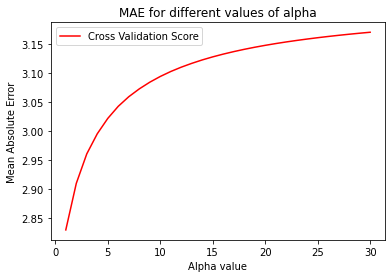

The lowest MAE is 2.829434692632794 with a regularization term of 1
The MAE of the test set is 2.866447672760307


In [33]:
# Ridge with w2v
reg_term_list = list(range(1,31))

cv_scores = []
best_score = np.inf
best_alpha = []

for alpha in reg_term_list: 
    rr = Ridge(alpha=alpha)
    cv_score = np.mean(cross_val_score(rr, X_train_w2v, y_train, cv=5, scoring=scoring))*-1

    cv_scores.append(cv_score)

    if cv_score < best_score:
        best_score = cv_score
        best_alpha = alpha

plt.figure()
plt.plot(reg_term_list, cv_scores, color='red', label = 'Cross Validation Score')
plt.title('MAE for different values of alpha')
plt.xlabel('Alpha value')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

print(f'The lowest MAE is {best_score} with a regularization term of {best_alpha}') 

# recreate best model and test against test set
w2v_rr_best = Ridge(alpha=best_alpha)
w2v_rr_best.fit(X_train_w2v, y_train) 

y_pred = w2v_rr_best.predict(X_test_w2v)
w2v_best_rr_clipped_mae = clipped_mae(y_test, y_pred)

print(f'The MAE of the test set is {w2v_best_rr_clipped_mae}')

### Ridge regression with GloVe

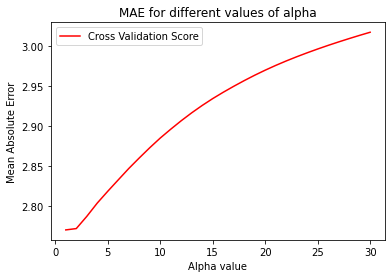

The lowest MAE is 2.769781133280677 with a regularization term of 1
The MAE of the test set is 2.88721491281618


In [34]:
# Ridge with GloVe
reg_term_list = list(range(1,31))

cv_scores = []
best_score = np.inf
best_alpha = []

for alpha in reg_term_list: 
    rr = Ridge(alpha=alpha)
    cv_score = np.mean(cross_val_score(rr, X_train_glove, y_train, cv=5, scoring=scoring))*-1

    cv_scores.append(cv_score)

    if cv_score < best_score:
        best_score = cv_score
        best_alpha = alpha

plt.figure()
plt.plot(reg_term_list, cv_scores, color='red', label = 'Cross Validation Score')
plt.title('MAE for different values of alpha')
plt.xlabel('Alpha value')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

print(f'The lowest MAE is {best_score} with a regularization term of {best_alpha}') 

# recreate best model and test against test set
glove_rr_best = Ridge(alpha=best_alpha)
glove_rr_best.fit(X_train_glove, y_train) 

y_pred = glove_rr_best.predict(X_test_glove)
glove_best_rr_clipped_mae = clipped_mae(y_test, y_pred)

print(f'The MAE of the test set is {glove_best_rr_clipped_mae}')

The last two models both perform worse than our best model, Ridge regression (MAE = 2.58). We will exclude these neural networks from further investigation. 
***

# Conclusion 
In this notebook we used GridSearchCV to optimize the hyperparameters of different models (Ridge regression, Lasso regression, Decision Tree Regressor, KNN Regressor, and XGB Regressor) which helped determine which of these models performed the best. GridSearchCV uses cross validation scores to determine which model performs the best. We also compared how Bag of Words and TF-IDF to see which form of text representation resulted in the best cross validation score. The best models found were Ridge regression with TF-IDF vectorization (MAE=2.58), and XGBRegressor with TF-IDF vectorization (MAE=2.49). 

While the XGBRegressor model performed the best, it lacks the level of interpretability that we are looking for. We want to see how individual words affect the predicted rating of a whisky, and this is not possible with XGBoost regression models. We could perhaps look at the feature importances of our XGB regression model, but that does not indicate whether a word increases or decreases a whisky's rating. Due to to lack of interpretability, this is not a model we will be investigating further.  

We also fit neural networks using TF-IDF vectorization, and word2vec and GlovE word embeddings. These models did not perform as well as Ridge regression and the XGB Regressor and will not be investigated further. Please note that there was no attempt at optimizing the neural network. The main goal of this investigation was to observe the regression coefficients of whisky reviews to determine which words increase and decrease the whisky's rating. This level of interpretability is largely lost when using neural networks. We fit these models mainly out of curiousity to see if they were more accurate than our other models without tuning hyperparameters. 

Finally, we fit Ridge regression models using word2vec and GloVe word embeddings as well. These models also did not perform as well as Ridge regression and XGB Regressor with TF-IDF vectorization.  

In our next notebook, we will further investigate Ridge regression with TF-IDF text vectorization. 